![imaging2/4](https://img.shields.io/badge/imaging2/4-lightgrey)
[![Jupyter Notebook](https://img.shields.io/badge/Source%20on%20GitHub-orange)](https://github.com/laminlabs/lamin-usecases/blob/main/docs/imaging2.ipynb)

# Generate single-cell images

Here, we are going to process the previously ingested microscopy images with the [scPortrait](https://github.com/MannLabs/scPortrait) pipeline to generate single-cell images that we can use to asses autophagosome formation at a single-cell level.

In [1]:
import lamindb as ln
from collections.abc import Iterable

from pathlib import Path
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose

ln.track()

→ connected lamindb: sophiamaedler/test-imaging


/Users/sophia/mambaforge/envs/lamin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


→ created Transform('nvOvUtdk7bUl0000'), started new Run('VymrcTQO...') at 2025-03-21 14:43:34 UTC
→ notebook imports: lamindb==1.3.0 scportrait==1.3.2


First, we query for the raw and annotated microscopy images.

In [2]:
input_images = (
    ln.Artifact.filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .filter(suffix=".tif")
)

The experiment contains different genotypes (`WT` and `EI24KO`) that were treated differently (`unstimulated` vs `14h Torin-1`).
For each condition multiple clonal cell lines and imaged multiple FOVs in all of the imaging channels are available.
To properly process this dataset we will need to get single-cell images from each FOV indivdually and tag them with all of the appropriate metadata so that we can identify genotype, treatment condition, clonal cell line and imaging experiment. 

In [3]:
select_artifacts_df = (
    ln.Artifact.filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .df(features=True)
)
display(select_artifacts_df.head())

conditions = list(set.union(*select_artifacts_df["stimulation"].values))
cell_line_clones = list(set.union(*select_artifacts_df["cell_line_clone"].values))
FOVs = list(set.union(*select_artifacts_df["FOV"].values))

,uid,key,description,study,imaged structure,microscope,magnification,FOV,channel,cell_line_clone,stimulation,genotype,resolution
id,,,,,,,,,,,,,
2,uzRJsneHdxl4vT850000,None,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{LckLip-mNeon},{Opera Phenix},{20X},{FOV1},{Alexa488},{U2OS lcklip-mNeon mCherryLC3B clone 1},{14h Torin-1},{WT},{0.597976081}
3,v62bKBdgNR3qT5Ot0000,None,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{LckLip-mNeon},{Opera Phenix},{20X},{FOV2},{Alexa488},{U2OS lcklip-mNeon mCherryLC3B clone 1},{14h Torin-1},{WT},{0.597976081}
4,w7Od5Bw8EfSHSiuo0000,None,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{DNA},{Opera Phenix},{20X},{FOV1},{DAPI},{U2OS lcklip-mNeon mCherryLC3B clone 1},{14h Torin-1},{WT},{0.597976081}
5,77QlH2RnmEO0tMuh0000,None,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{DNA},{Opera Phenix},{20X},{FOV2},{DAPI},{U2OS lcklip-mNeon mCherryLC3B clone 1},{14h Torin-1},{WT},{0.597976081}
6,DofJQDZjIABeds8x0000,None,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{mCherry-LC3B},{Opera Phenix},{20X},{FOV1},{mCherry},{U2OS lcklip-mNeon mCherryLC3B clone 1},{14h Torin-1},{WT},{0.597976081}


Alternatively, you can also query for the Ulabel's directly.

In [4]:
conditions = ln.ULabel.filter(
    links_artifact__feature__name="stimulation", artifacts__in=input_images
).distinct()
cell_line_clones = ln.ULabel.filter(
    links_artifact__feature__name="cell_line_clone", artifacts__in=input_images
).distinct()
FOVs = ln.ULabel.filter(
    links_artifact__feature__name="FOV", artifacts__in=input_images
).distinct()

By iterating through conditions, celllines and FOVs, we should only have the 3 images showing a single FOV. By ingesting our common config file we can now process them in scPortrait.

In [5]:
# load config file for processing all datasets
config_file_af = ln.Artifact.using("scportrait/examples").get(
    key="input_data_imaging_usecase/config.yml"
)
config_file_af.description = (
    "config for scportrait for processing of cells stained for autophagy markers"
)
config_file_af.save()

# annotate the config file with the metadata relevant to the study
config_file_af.features.add_values(
    {"study": "autophagy imaging", "artifact type": "scportrait config"}
)

→ mapped records: ULabel(uid='PKiCEP1h')
→ transferred records: Artifact(uid='voi8szTkmKPiahUA0000'), ULabel(uid='hbGRGfA1'), Feature(uid='Kb0eQtlXapg2')


Lets take a look at the processing of one example FOV.

In [6]:
# get input images for one example FOV
condition = conditions[0]
cellline = cell_line_clones[0]
FOV = FOVs[0]

images = (
    input_images.filter(ulabels=condition)
    .filter(ulabels=cellline)
    .filter(ulabels=FOV)
    .distinct()
)

# Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
_features = []
values_to_ignore = ["channel", "imaged structure"]

for af in images:
    features = af.features.get_values()
    features = {
        key: features[key] for key in features.keys() if key not in values_to_ignore
    }
    _features.append(features)
assert all(_features[0] == f for f in _features)
shared_features = _features[0]

# bring image paths into the correct order for processing
input_image_paths = [
    images.filter(ulabels__name=channel_name).one().cache()
    for channel_name in ["DAPI", "Alexa488", "mCherry"]
]

In [7]:
# define and create an output location for the processed data
output_directory = "processed_data"
Path(output_directory).mkdir(parents=True, exist_ok=True)

# initialize our scportrait project with a unique ID
unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
    " ", "_"
)

# create the project location
project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
Path(project_location).mkdir(parents=True, exist_ok=True)

# initialize the project
project = Project(
    project_location=project_location,
    config_path=config_file_af.cache(),
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    overwrite=True,
)

# load our input images
project.load_input_from_tif_files(
    input_image_paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
)

# process the project
project.segment()
project.extract()

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_clone_1/14h_Torin-1/FOV1/scportrait_project/scportrait.sdata 


Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


First, lets look at the input images we processed.

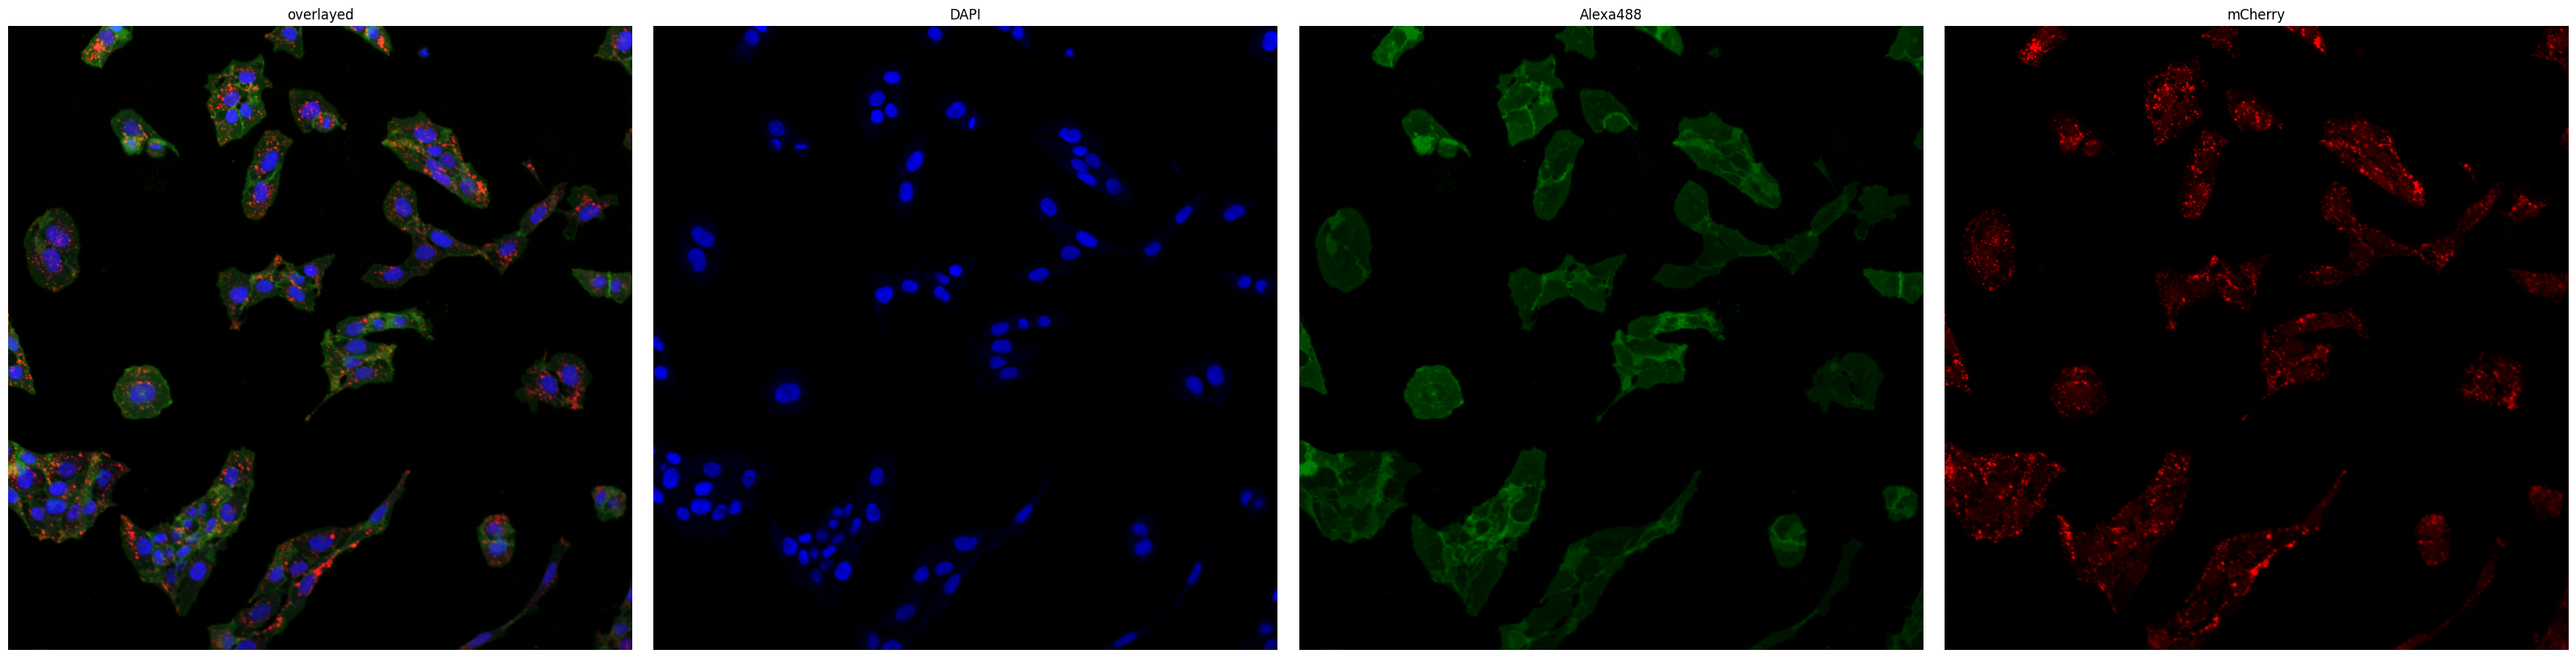

In [8]:
project.plot_input_image()

Now we can look at the results generated by scPortrait. First the segmentation masks.

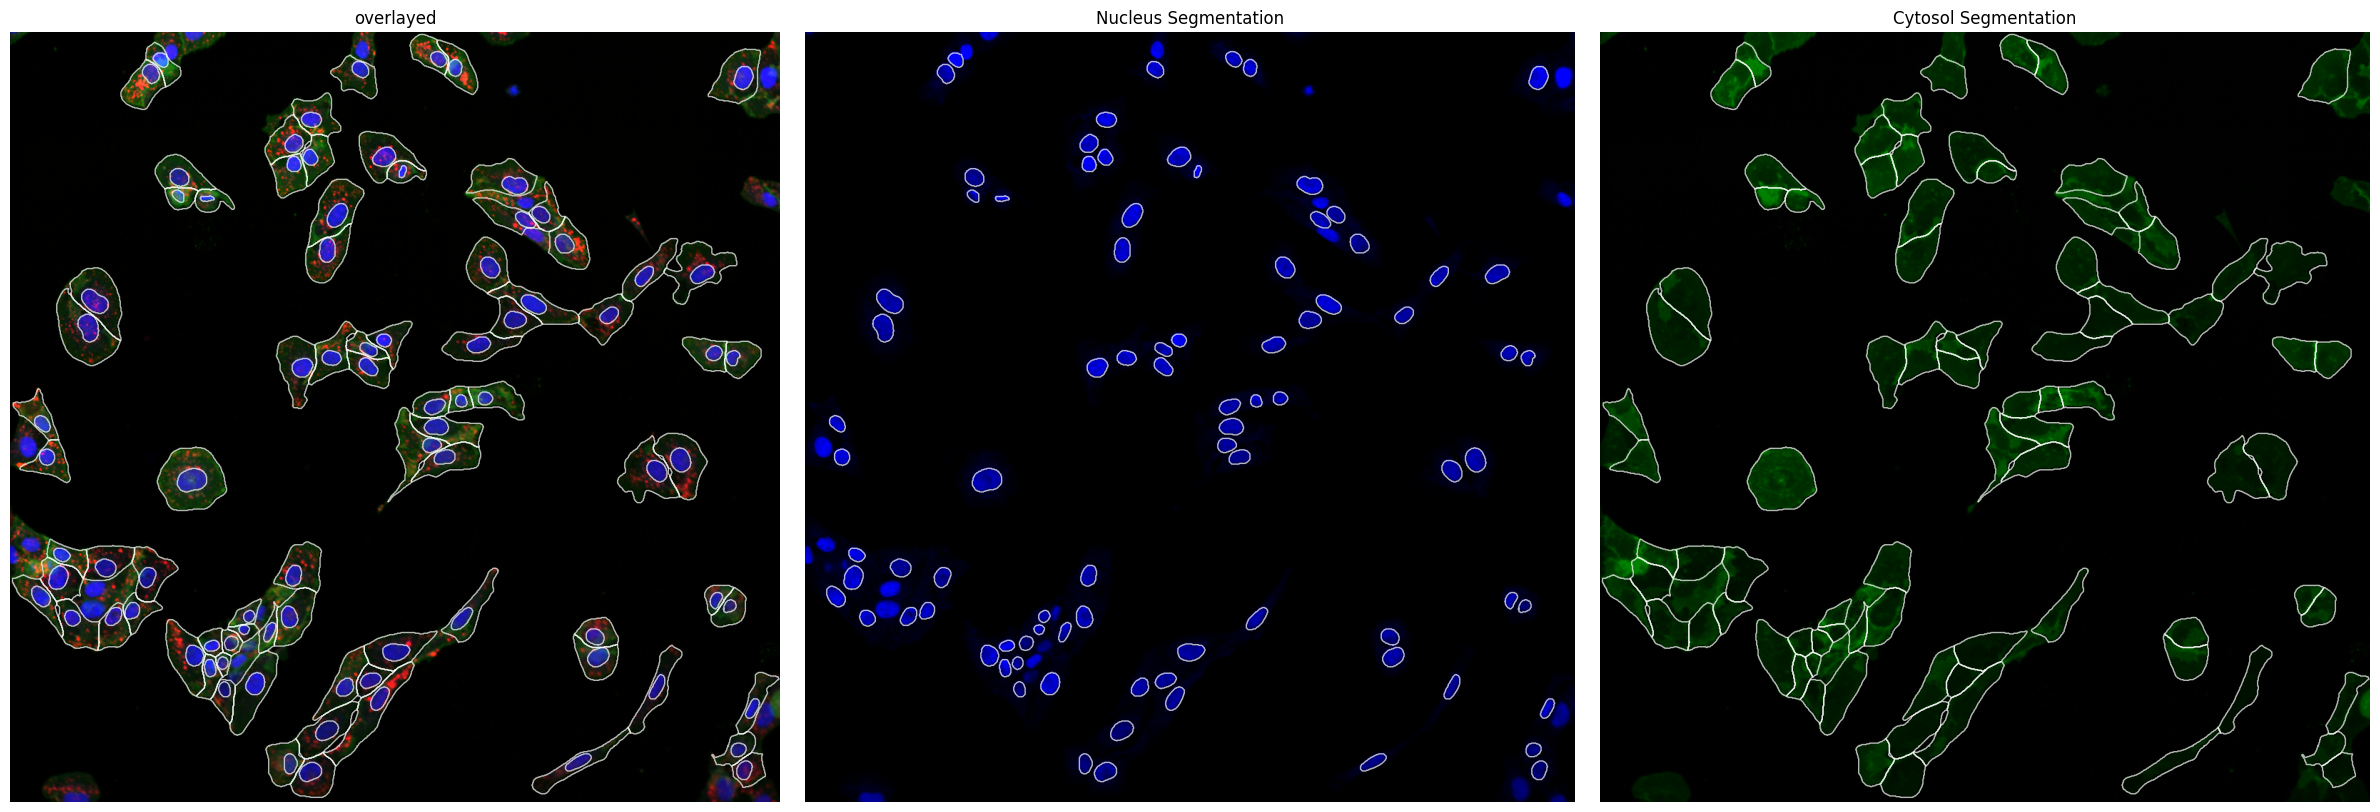

In [9]:
project.plot_segmentation_masks()

And then extraction results consisting of individual single-cell images over all of the channels.

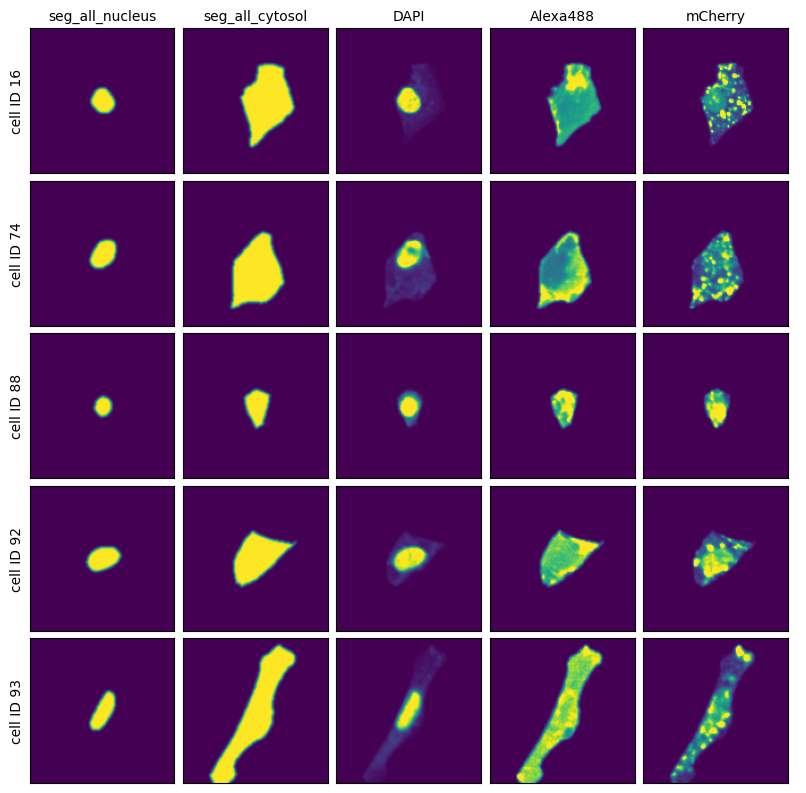

In [10]:
project.plot_single_cell_images()

Now we also want to save these results to our instance. 

In [11]:
ln.Artifact.from_spatialdata(
    sdata=project.filehandler.get_sdata(),
    description="scportrait spatialdata object containing results of cells stained for autophagy markers",
    key=f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr",
).save()

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /Users/sophia/Library/Caches/lamindb/iSbOzox3SmFVcTTy0000.zarr). Please see the         
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_clone_1/14h_Torin-1/FOV1/scportrait_project/scportrait.sdata 
         the new file path: /Users/sophia/Library/Caches/lamindb/iSbOzox3SmFVcTTy0000.zarr                         


Artifact(uid='iSbOzox3SmFVcTTy0000', is_latest=True, key='processed_data_imaging_use_case/U2OS_lcklip-mNeon_mCherryLC3B_clone_1/14h_Torin-1/FOV1/spatialdata.zarr', description='scportrait spatialdata object containing results of cells stained for autophagy markers', suffix='.zarr', kind='dataset', otype='SpatialData', size=6997749, hash='tVhwRIUGDPWtzv7cPkxIKw', n_files=54, space_id=1, storage_id=1, run_id=3, created_by_id=1, created_at=2025-03-21 14:43:49 UTC)

In [12]:
# define var schema
var_schema = ln.Schema(
    name="single-cell image dataset schema var",
    description="column schema for data measured in obsm[single_cell_images]",
    itype=ln.Feature,
    dtype=float,
).save()

# define obs schema
obs_schema = ln.Schema(
    name="single-cell image dataset schema obs",
    features=[
        ln.Feature(name="cell_id", dtype="int", coerce_dtype=True).save(),
    ],
).save()

# define uns schema
uns_schema = ln.Schema(
    name="single-cell image dataset schema uns",
    itype=ln.Feature,
    dtype=dict,
).save()

# define composite schema
h5sc_schema = ln.Schema(
    name="single-cell image dataset",
    otype="AnnData",
    components={"var": var_schema, "obs": obs_schema, "uns": uns_schema},
).save()

# curate an AnnData
curator = ln.curators.AnnDataCurator(project.h5sc, h5sc_schema)
curator.validate()
artifact = curator.save_artifact(
    key=f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad"
)

# add shared annotation
annotation = shared_features.copy()
annotation["imaged structure"] = [
    ln.ULabel.using("scportrait/examples").get(name=structure_name)
    for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
]

artifact.features.add_values(annotation)
artifact.labels.add(ln.ULabel(name="scportrait single-cell images").save())

! records with similar names exist! did you mean to load one of them?


,uid,name,dtype,is_type,unit,description,array_rank,array_size,array_shape,proxy_dtype,synonyms,_expect_many,_curation,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,
3,jFVKf8mmL3Rt,cell_line,cat[bionty.CellLine.name],None,None,None,0,0,None,None,None,True,None,1,None,1,2025-03-21 14:28:18.865000+00:00,1,"{'af': {'0': None, '1': True, '2': False}}",1
4,lyUy1nuQSoS8,cell_line_clone,cat[ULabel.name],None,None,None,0,0,None,None,None,True,None,1,None,1,2025-03-21 14:28:18.867000+00:00,1,"{'af': {'0': None, '1': True, '2': False}}",1


! record with similar name exists! did you mean to load it?


,uid,name,description,n,dtype,itype,is_type,otype,hash,minimal_set,ordered_set,maximal_set,_curation,slot,space_id,type_id,validated_by_id,composite_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
2,3dG1PtRNp6pmpCVuR6o7,single-cell image dataset schema var,column schema for data measured in obsm[single...,-1,float,Feature,False,None,2LXd3Ex5pNOrDsqEiHkuVw,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.946000+00:00,1,None,1


! records with similar names exist! did you mean to load one of them?


,uid,name,description,n,dtype,itype,is_type,otype,hash,minimal_set,ordered_set,maximal_set,_curation,slot,space_id,type_id,validated_by_id,composite_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
2,3dG1PtRNp6pmpCVuR6o7,single-cell image dataset schema var,column schema for data measured in obsm[single...,-1,float,Feature,False,None,2LXd3Ex5pNOrDsqEiHkuVw,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.946000+00:00,1,None,1
3,PUwajeoyOFo5TGdoSlPw,single-cell image dataset schema obs,None,1,None,Feature,False,None,1j9UbOOFnijksoThNUnoeg,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.969000+00:00,1,None,1


! records with similar names exist! did you mean to load one of them?


,uid,name,description,n,dtype,itype,is_type,otype,hash,minimal_set,ordered_set,maximal_set,_curation,slot,space_id,type_id,validated_by_id,composite_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
2,3dG1PtRNp6pmpCVuR6o7,single-cell image dataset schema var,column schema for data measured in obsm[single...,-1,float,Feature,False,None,2LXd3Ex5pNOrDsqEiHkuVw,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.946000+00:00,1,None,1
3,PUwajeoyOFo5TGdoSlPw,single-cell image dataset schema obs,None,1,None,Feature,False,None,1j9UbOOFnijksoThNUnoeg,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.969000+00:00,1,None,1
4,W13tAqNam5P7HAnEWw5D,single-cell image dataset schema uns,None,-1,dict,Feature,False,None,eM1K4iIPtsi5Lc7ONRL_aQ,True,False,False,None,None,1,None,None,None,3,2025-03-21 14:43:49.979000+00:00,1,None,1


• path content will be copied to default storage upon `save()` with key 'processed_data_imaging_use_case/U2OS_lcklip-mNeon_mCherryLC3B_clone_1/14h_Torin-1/FOV1/single_cell_data.h5ad'
✓ storing artifact 'jryk1izEoNnZgzVR0000' at '/Users/sophia/Documents/GitHub/lamin-usecases/docs/test-imaging/.lamindb/jryk1izEoNnZgzVR0000.h5ad'
• parsing feature names of X stored in slot 'var'
!    5 unique terms (100.00%) are not validated for name: '0', '1', '2', '3', '4'
! skip linking features to artifact in slot 'var'
• parsing feature names of slot 'obs'
✓    1 unique term (100.00%) is validated for name
→    returning existing schema with same hash: Schema(uid='PUwajeoyOFo5TGdoSlPw', name='single-cell image dataset schema obs', n=1, itype='Feature', is_type=False, hash='1j9UbOOFnijksoThNUnoeg', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=1, run_id=3, created_at=2025-03-21 14:43:49 UTC)
!    updated otype from None to DataFrame
✓    linked: Schema(uid='PUwajeo

To make our lives easier so that we can process all of the files in our dataset we are going to write a custom image processing function.
We decorate this function with :func:`~lamindb.tracked` to track data lineage of the input and output Artifacts. To improve processing time we will only recompute datasets that have not been previously processed and uploaded to our instance.

In [13]:
@ln.tracked()
def _process_images(
    config_file_af: ln.Artifact,
    input_artifacts: Iterable[ln.Artifact],
    h5sc_schema: ln.Schema,
    output_directory: str,
) -> None:
    # Perform quick sanity check that we only have images which share all of their attributes except channel and imaged structure
    _features = []
    values_to_ignore = ["channel", "imaged structure"]

    for af in input_artifacts:
        features = af.features.get_values()
        features = {
            key: features[key] for key in features.keys() if key not in values_to_ignore
        }
        _features.append(features)
    assert all(_features[0] == f for f in _features)
    shared_features = _features[0]

    # create a unique identifier for the project based on the annotated features
    unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

    # check if processed results already exist and if so skip processing
    try:
        # check for single-cell images
        (
            ln.Artifact.using("scportrait/examples").get(
                key=f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad"
            )
        )

        # check for spatialdata object
        (
            ln.Artifact.using("scportrait/examples").get(
                key=f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr"
            )
        )
        print(
            "Dataset already processed and results uploaded to instance. Skipping processing."
        )

    except:
        input_image_paths = [
            input_artifacts.filter(ulabels__name=channel_name).one().cache()
            for channel_name in ["DAPI", "Alexa488", "mCherry"]
        ]

        # create the project location
        project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
        Path(project_location).mkdir(parents=True, exist_ok=True)

        project = Project(
            project_location=project_location,
            config_path=config_file_af.cache(),
            segmentation_f=CytosolSegmentationCellpose,
            extraction_f=HDF5CellExtraction,
            overwrite=True,
        )

        # process the project
        project.load_input_from_tif_files(
            input_image_paths,
            overwrite=True,
            channel_names=["DAPI", "Alexa488", "mCherry"],
        )
        project.segment()
        project.extract()

        # ingest results to instance

        # single-cell images
        curator = ln.curators.AnnDataCurator(project.h5sc, h5sc_schema)
        artifact = curator.save_artifact(
            key=f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad"
        )
        annotation = shared_features.copy()
        annotation["imaged structure"] = [
            ln.ULabel.using("scportrait/examples").get(name=structure_name)
            for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
        ]
        artifact.features.add_values(annotation)
        artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))

        # spatialdata object
        ln.Artifact.from_spatialdata(
            sdata=project.filehandler.get_sdata(),
            description="scportrait spatialdata object containing results of cells stained for autophagy markers",
            key=f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr",
        ).save()

    return None

In [14]:
ln.Param(name="output_directory", dtype="str").save()

Param(name='output_directory', dtype='str', space_id=1, created_by_id=1, run_id=3, created_at=2025-03-21 14:43:50 UTC)

Now we are ready to process all of our input images and upload the generated single-cell image datasets back to our instance.

In [15]:
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )

            if images:
                _process_images(
                    config_file_af,
                    input_artifacts=images,
                    h5sc_schema=h5sc_schema,
                    output_directory=output_directory,
                )

! cannot infer feature type of: <QuerySet [Artifact(uid='uzRJsneHdxl4vT850000', is_latest=True, description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='0aoXxT857VvKAGo9UQo-8g', space_id=1, storage_id=1, run_id=1, created_by_id=1, created_at=2025-03-21 14:28:30 UTC), Artifact(uid='w7Od5Bw8EfSHSiuo0000', is_latest=True, description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='YRjhTt2cBLq3BukWLUKC_w', space_id=1, storage_id=1, run_id=1, created_by_id=1, created_at=2025-03-21 14:28:30 UTC), Artifact(uid='DofJQDZjIABeds8x0000', is_latest=True, description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='zptjd_tR7P2Nw6mjUWbEjw', space_id=1, storage_id=1, run_id=1, created_by_id=1, created_at=2025-03-21 14:28:32 UTC)]>, returning '?
Dataset already processed and results uploaded to instance. Skipping processing.
! cannot infer feature type of: <QuerySet [Ar

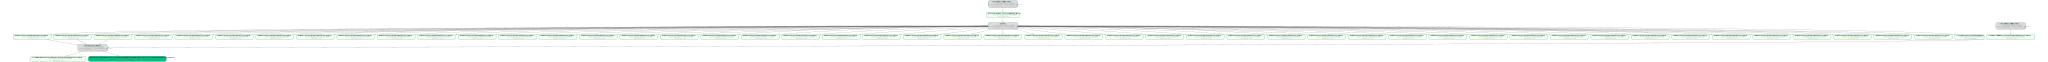

In [16]:
example_artifact = ln.Artifact.filter(
    ulabels=ln.ULabel.get(name="scportrait single-cell images")
)[0]
example_artifact.view_lineage()

In [17]:
ln.finish()

• please hit CMD + s to save the notebook in your editor .... still waiting .....
......... ✓


/Users/sophia/mambaforge/envs/lamin/lib/python3.12/site-packages/nbformat/__init__.py:96: DuplicateCellId: Non-unique cell id '27' detected. Corrected to 'd93abc03'.
  validate(nb)


→ finished Run('VymrcTQO') after 37s at 2025-03-21 14:44:12 UTC


/Users/sophia/mambaforge/envs/lamin/lib/python3.12/site-packages/nbformat/__init__.py:96: DuplicateCellId: Non-unique cell id '27' detected. Corrected to '81a39bf2'.
  validate(nb)
